### Model

In [1]:
import libs.forward_model as fm
import libs.read_data as rd
import torch
import torch.optim as optim
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# Parameter Definition
NA = .8
Rindex= 1
lambda_= 532.0/ 1000 #um
dx, dy, dz= .1,.1,.5 #um
ep_dx, ep_dy =.2,.2
Nx,Ny,Nz = 16,16,8
m = 12
down_factor = .5


fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m, ep_dx__=ep_dx, ep_dy__=ep_dy)
rd.init_parameters(Nx,Ny,Nz)
fm.init_one_shot(m, down_factor=down_factor,num_planes=1)

def one_shot_model(X):
    return torch.matmul(fm.A,X)

print(f"Shape of matrix A: {fm.A.shape}")

e:\Python_VENV\FRIS\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!
Matrix A is intialized sucessfully...!!!
Shape of matrix A: torch.Size([768, 2048])


## Reconstruction
$$y=A\cdot x\implies b = (A^{\tiny T}\cdot A)\cdot x\qquad where\quad b = A^{\tiny T}\cdot y$$


In [3]:
ATA = (fm.A.T@fm.A).float()
print("Conditional Number: ","{:.4e}".format(torch.linalg.cond(ATA)))
print(f"Rank : {torch.linalg.matrix_rank(ATA)}")

Conditional Number:  9.5639e+12
Rank : 126


***Basic Solution***
$$Y = A\cdot X \implies A^{\tiny T}\cdot Y  = (A^{\tiny T}\cdot A)\cdot X\implies X = (A^{\tiny T}\cdot A)^{-1}\cdot A^{\tiny T}\cdot Y$$

In [6]:
def reconstruct_image_basic(y):
    A_pseudo_inv = torch.linalg.pinv(fm.A)   # torch.linalg.pinv(A.T@A)@A.T
    return torch.matmul(A_pseudo_inv, y)

***LU Decomposition Based Solution***

In [ ]:
def reconstruct_image_lu(y):
    b = (fm.A.T@y).view(-1,1)
    LU, pivots = torch.lu(ATA)
    return torch.lu_solve(b, LU, pivots)

***Cholesky Decomposition Based Solution***

In [ ]:
def reconstruct_image_ch(y):
    b = (fm.A.T@y).view(-1,1)
    U = torch.cholesky(ATA, upper=False)
    return torch.cholesky_solve(b, U, upper=False)

***Gradient Descent Based***

$$x_0\xrightarrow{\texttt{Loss Calculation}}L =\| Ax_0 - b\|\xrightarrow{\texttt{Gradient Descent}}x_1\dots \to L=0$$ 

In [ ]:
def reconstruct_image_gd(y, learning_rate = 1e-1, num_iter = 50000):
    # RANDOM INTIALIZATION OF X
    x = torch.autograd.Variable(torch.rand(Nx*Ny*Nz,1,dtype = torch.float32).to(device), requires_grad=True)

    # Define the optimizer
    optimizer = optim.SGD([x], lr=learning_rate)

    # Gradient descent optimization loop
    for iter in range(num_iter+1):
        loss = torch.norm(fm.A@x-y,p=2)
        loss.backward()
        optimizer.step()
        if(iter%10000 == 0):
            print(f"At Iteration {iter} Error is: {loss}")
        optimizer.zero_grad()
    return x

***Results***

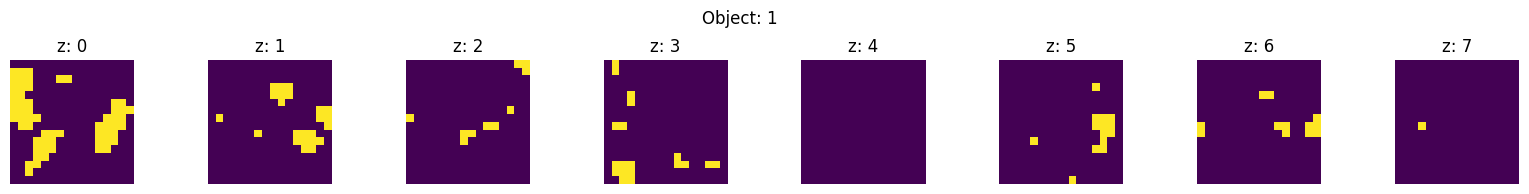

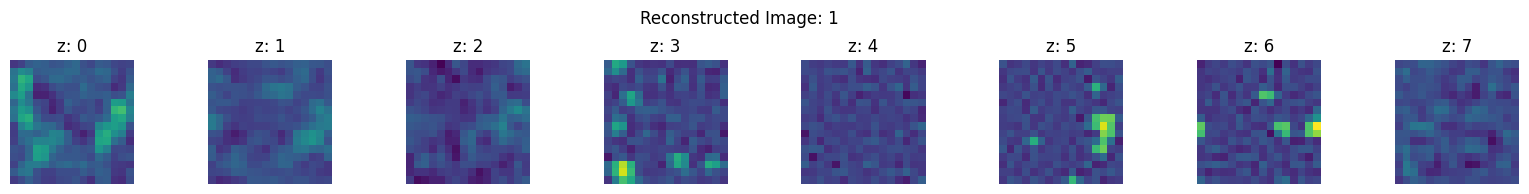

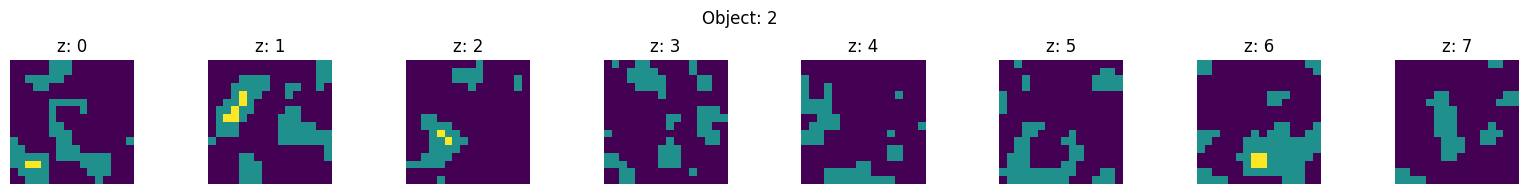

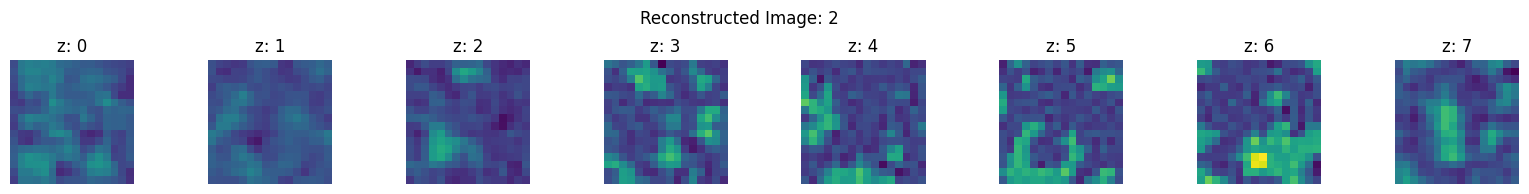

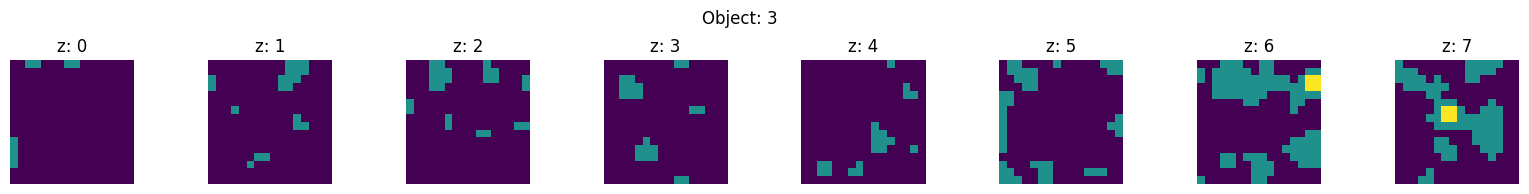

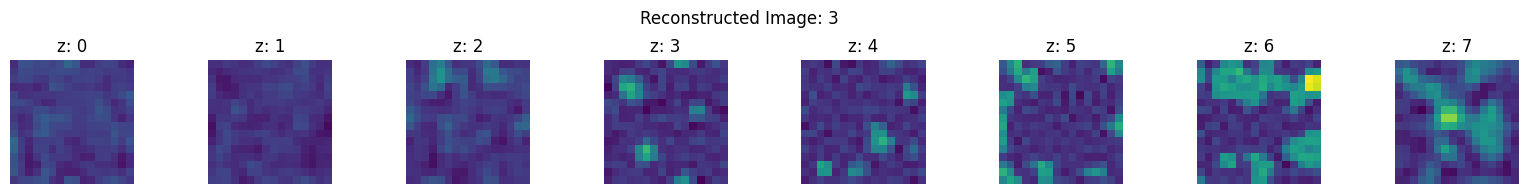

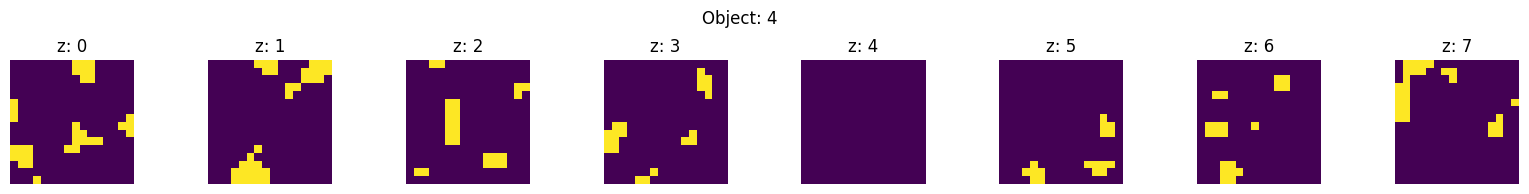

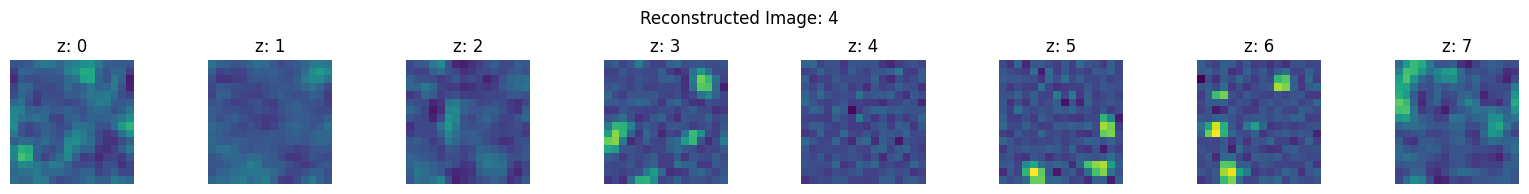

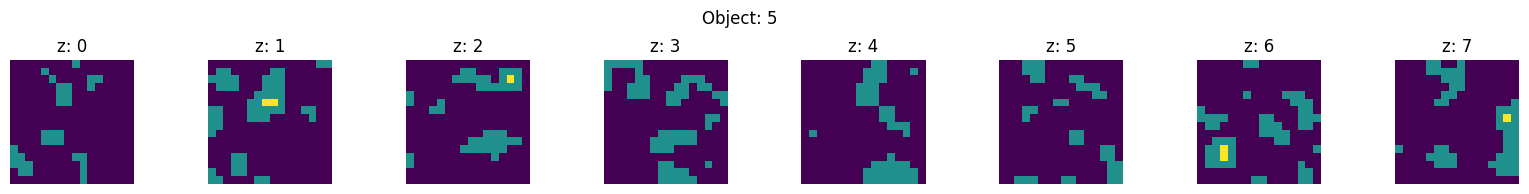

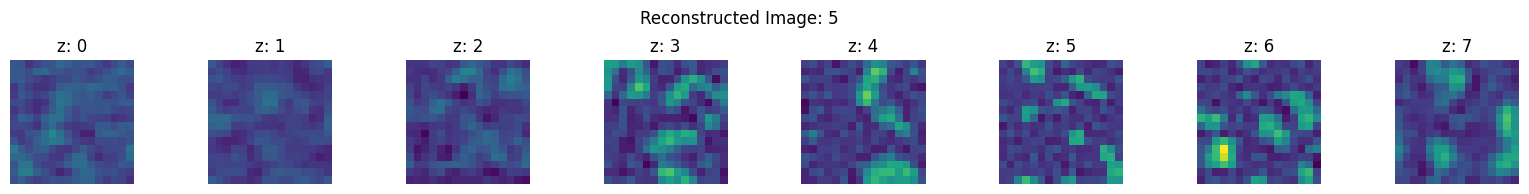

In [3]:
for c_ in range(5):
    rd.load_object("neural_cell", verbose=False)
    X_original = (rd.X).flatten()
    Y = one_shot_model(X_original)
    # X_reconstructed = reconstruct_image_gd(Y)    
    X_reconstructed = torch.linalg.lstsq(fm.A,Y).solution   
    X3D_recons = X_reconstructed.view(Nz,Nx, Ny)
    X3D_orig = X_original.view(Nz,Nx,Ny)
    fm.show_planes_z(X3D_orig.detach().cpu().numpy(),f"Object: {c_+1}",[i for i in range(Nz)])
    fm.show_planes_z(X3D_recons.detach().cpu().numpy(),f"Reconstructed Image: {c_+1}",[i for i in range(Nz)])

### Bringing More Planes in Reconstruction

In [2]:
# Parameter Definition
NA = .8
Rindex= 1
lambda_= 532.0/ 1000 #um
dx, dy, dz= .1,.1,.5 #um
ep_dx, ep_dy =.2,.2
Nx,Ny,Nz = 16,16,8
m = 8
down_factor = .5


fm.init_parameters(NA_=NA, Rindex_=Rindex, lambda_=lambda_, dx_=dx, dy_=dy, dz_=dz, Nx_=Nx, Ny_=Ny, Nz_=Nz)
fm.init_DMD_patterns(m, ep_dx__=ep_dx, ep_dy__=ep_dy)
rd.init_parameters(Nx,Ny,Nz)
fm.init_one_shot(m, down_factor=down_factor,num_planes=2)

def one_shot_model(X):
    return torch.matmul(fm.A,X)

print(f"Shape of matrix A: {fm.A.shape}")

e:\Python_VENV\FRIS\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Sucessfully Initialized Point Spread Function...!!!
Sucessfully Initialized Read Data Parameters...!!!
Matrix A is intialized sucessfully...!!!
Shape of matrix A: torch.Size([1024, 2048])


In [3]:
ATA = (fm.A.T@fm.A).float()
print("Conditional Number: ","{:.4e}".format(torch.linalg.cond(ATA)))
print(f"Rank : {torch.linalg.matrix_rank(ATA)}")

Conditional Number:  1.1827e+12
Rank : 176


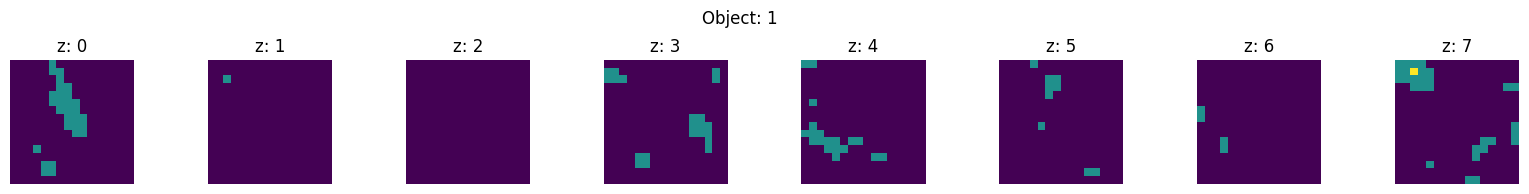

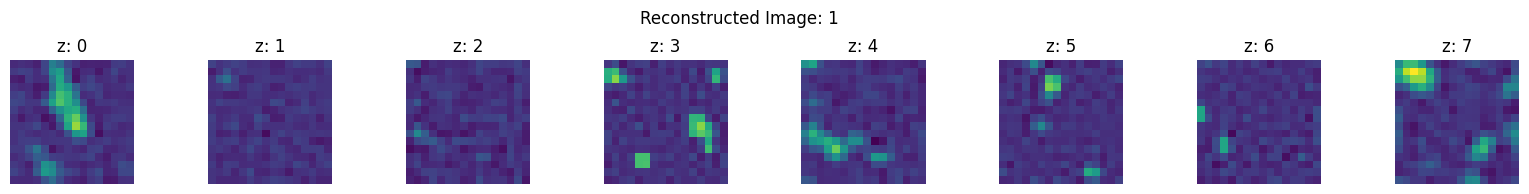

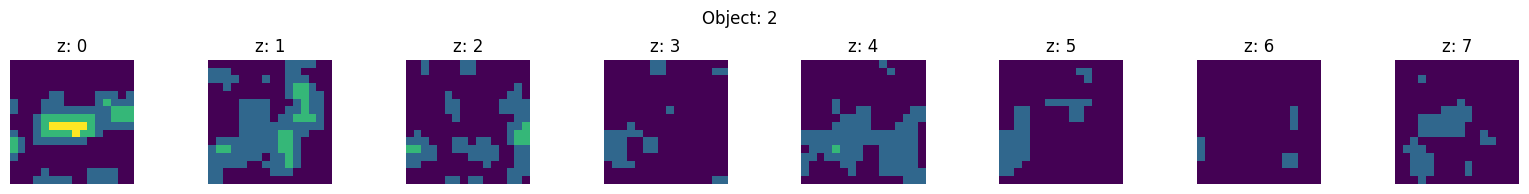

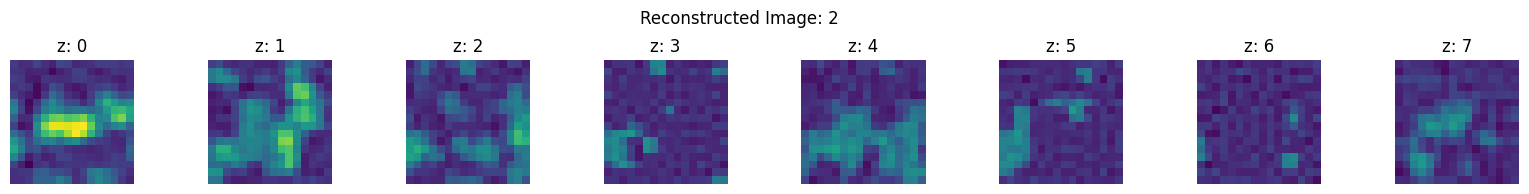

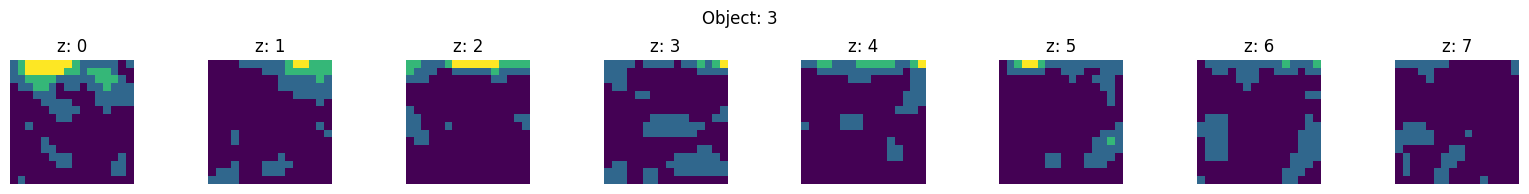

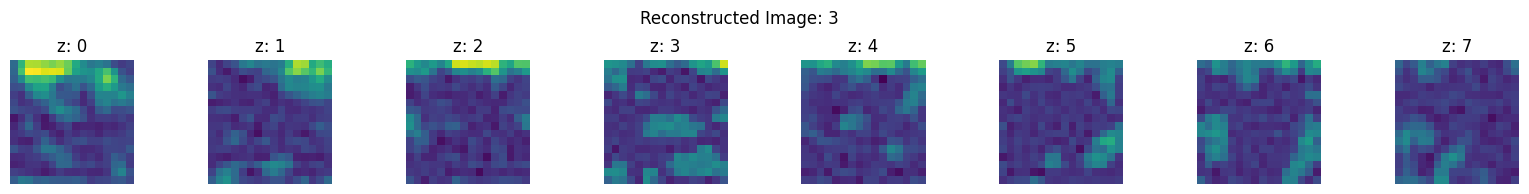

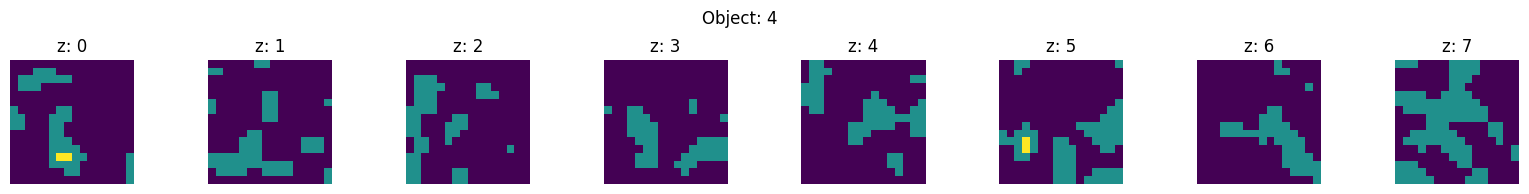

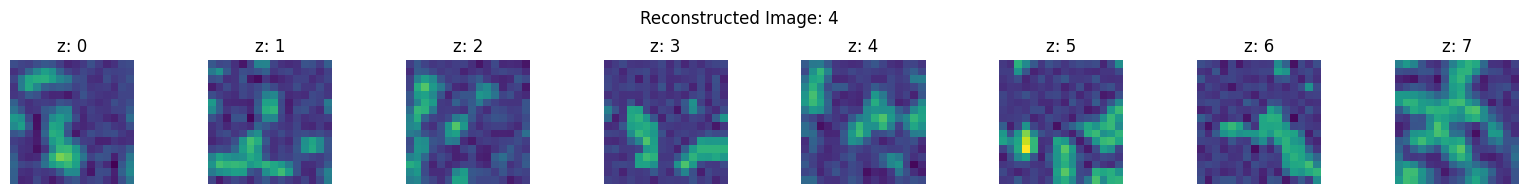

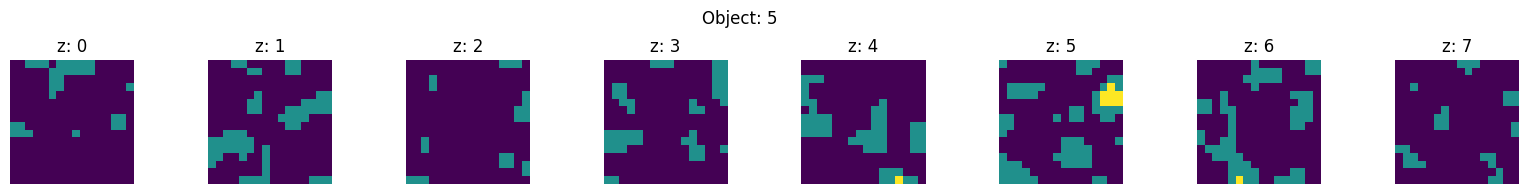

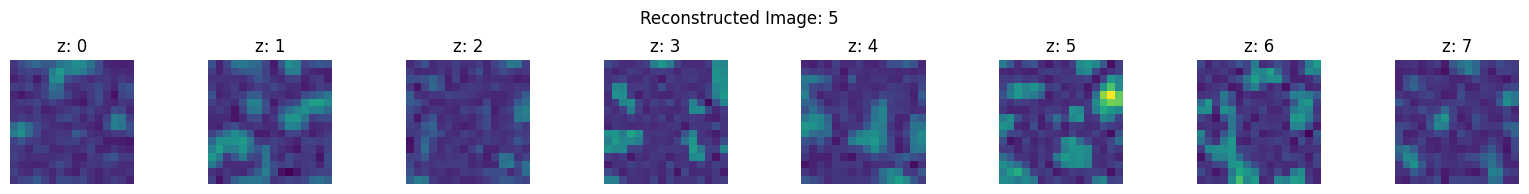

In [4]:
for c_ in range(5):
    rd.load_object("neural_cell", verbose=False)
    X_original = (rd.X).flatten()
    Y = one_shot_model(X_original)
    # X_reconstructed = reconstruct_image_gd(Y)    
    X_reconstructed = torch.linalg.lstsq(fm.A,Y).solution   
    X3D_recons = X_reconstructed.view(Nz,Nx, Ny)
    X3D_orig = X_original.view(Nz,Nx,Ny)
    fm.show_planes_z(X3D_orig.detach().cpu().numpy(),f"Object: {c_+1}",[i for i in range(Nz)])
    fm.show_planes_z(X3D_recons.detach().cpu().numpy(),f"Reconstructed Image: {c_+1}",[i for i in range(Nz)])